July 11, 2024 Project Collab Notebook

# Introduction


Fake news classification [based on the liar liar dataset](https://arxiv.org/pdf/1705.00648v1).

In [39]:
# !pip install contractions

In [38]:
# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# NLP libraries
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import contractions
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

lemmatizer = WordNetLemmatizer()

# start loading language library
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading Liar Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

data_path='/content/drive/My Drive/nma/datasets/'

Mounted at /content/drive/


In [ ]:
# data_path = '/content/'

## **Load the data**

In [18]:
# pof = pants on fire
df_train = pd.read_csv(data_path + 'train.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_train['type'] = 0

df_test = pd.read_csv(data_path +  'test.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_test['type'] = 1

df_valid = pd.read_csv(data_path + 'valid.tsv', sep='\t', names=["source", "truth_class",
                                                              "statement", "area", "speaker",
                                                              "speaker_role", "location", "party",
                                                              "pof_count", "false_count", "barely_true_count", "half_true_count",
                                                              "mostly_true_count", "media"])
df_valid['type'] = 2


In [19]:
# Concatenate all dataset for cleaning and eset index to ensure no duplicate index values
df_all = pd.concat([df_train, df_valid, df_test])

# Reset index
df_all = df_all.reset_index(drop=True)

In [8]:
# df_all.columns

## ** Data Cleaning and EDA**

In [20]:
df_all['statement'][0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [14]:
# # @title Visualise the target
# df_train.groupby('truth_class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

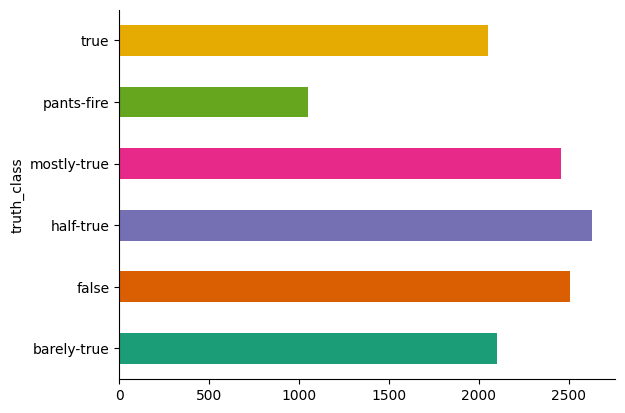

In [21]:
# @title Visualise the target
df_all.groupby('truth_class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             12791 non-null  object 
 1   truth_class        12791 non-null  object 
 2   statement          12791 non-null  object 
 3   area               12789 non-null  object 
 4   speaker            12789 non-null  object 
 5   speaker_role       9223 non-null   object 
 6   location           10040 non-null  object 
 7   party              12789 non-null  object 
 8   pof_count          12789 non-null  float64
 9   false_count        12789 non-null  float64
 10  barely_true_count  12789 non-null  float64
 11  half_true_count    12789 non-null  float64
 12  mostly_true_count  12789 non-null  float64
 13  media              12660 non-null  object 
 14  type               12791 non-null  int64  
dtypes: float64(5), int64(1), object(9)
memory usage: 1.5+ MB


In [22]:
# add a column for statement counts
df_all['statement_count'] = 0

role_counts = df_all['speaker'].value_counts()

# Map the counts to the 'count' column
df_all['statement_count'] = df_all['speaker'].map(role_counts)

# make the counts percents
df_all['pof_percent'] = df_all['pof_count']/df_all['statement_count']
df_all['false_percent'] = df_all['false_count']/df_all['statement_count']
df_all['barely_true_percent'] = df_all['barely_true_count']/df_all['statement_count']
df_all['half_true_percent'] = df_all['half_true_count']/df_all['statement_count']
df_all['mostly_true_percent'] = df_all['mostly_true_count']/df_all['statement_count']
df_all['true_percent'] = 1 - (df_all['pof_percent'] + df_all['false_percent'] + df_all['barely_true_percent']
                              + df_all['half_true_percent'] +  df_all['mostly_true_percent'])

In [23]:
# Label encoding:
# translate pants-fire, false, barelytrue, half-true, mostly-true, and true to 0, 1, 2, 3, 4, 5
label_encoded_dict = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

# Apply the label encoding to the "truth_class" column
df_all['truth_map'] = df_all['truth_class'].map(label_encoded_dict)


In [30]:
# df_all.columns

In [31]:
df_all.shape

(12791, 23)

In [27]:
# Replace 'none'

df_all['party'] = df_all['party'].replace('none', 'no_affiliation')
# df_all['party'] = df_all[df_all['party'] == 'none']['party'] = 'no_affiliation'

In [28]:
# check missing values per column
df_all.isnull().sum()

,0
source,0
truth_class,0
statement,0
area,2
speaker,2
speaker_role,3568
location,2751
party,2
pof_count,2
false_count,2


In [33]:
# df_all.columns

Processed the code to drop the "source" column - which contains json objects.

*   drop the rows where speaker is missing
*   fill missing values with "not_available"



In [34]:
# drop columns with the source - that's the json
df_proc = df_all.drop(columns='source')

# Drop rows where 'speaker' is missing
df_proc = df_proc.dropna(subset=['speaker'])

# Replace other missing values with 'not_available'
df_proc = df_proc.fillna('not_available')

In [35]:
# check missing values per column
df_proc.isnull().sum()

,0
truth_class,0
statement,0
area,0
speaker,0
speaker_role,0
location,0
party,0
pof_count,0
false_count,0
barely_true_count,0


In [ ]:
df_proc.shape

(12789, 22)

In [ ]:
# example statements
df_proc['statement'].iloc[0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [41]:
# df_proc['statement'][0:20]

In [42]:
# set text
text = df_proc['statement'] + ' ' + df_proc['speaker']
# change "," to " "; change "." to " "
text = text.apply(lambda x: re.sub("[.]", "", x))
text = text.apply(lambda x: re.sub("[,]", "", x))
# text

In [43]:
text.iloc[12]
# text = text.apply(lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]))
# text

'When Mitt Romney was governor of Massachusetts we didnt just slow the rate of growth of our government we actually cut it mitt-romney'

In [44]:
# Initialize stop words and set custom stop words
# negations = set(["not", "none", "nor", "never", "neither", "against"])
negations = set(["not", "none", "nor", "never", "neither", "against",
                 "aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't",
                 "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't",
                 "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't", "only"])
stop_words = set(stopwords.words('english')) - negations
# stop_words

In [45]:
# Preprocessing function
def preprocess_text(text):
  # Tokenization, lowercasing, and special character handling
  tokens = [token.text.lower() for token in nlp(text)]

  if (tokens[0] == 'says') or (tokens[0] == 'say'):
    tokens.pop(0)

  # Removing punctuation and stop words (conditionally)
  tokens = [re.sub(r'\W+', '', token) for token in tokens if token.isalnum() and token not in stop_words]

  # Lemmetization - also trying not to do this because it not helpful
  # tokens = [lemmatizer.lemmatize(x) for x in tokens]
  # print(tokens)

  # # Stemming - decided not to do stemming because it is too strong
  # tokens = [stemmer.stem(token) for token in tokens]
  # print(tokens)

  return ' '.join(tokens)

df_proc['processed_text'] = text.apply(preprocess_text)
processed_text = df_proc['processed_text']

In [46]:
processed_text

,processed_text
0,annies list political group supports third trimester abortions demand dwayne bohac
1,decline coal start started natural gas took started begin president george w bushs administration scott surovell
2,hillary clinton agrees john mccain voting give george bush benefit doubt iran barack obama
3,health care reform legislation likely mandate free sex change surgeries blog posting
4,economic turnaround started end term charlie crist
5,chicago bears starting quarterbacks last 10 years total number tenured uw faculty fired last two decades robin vos
6,jim dunnam not lived district represents years republican party texas
7,only person stage worked actively last year passing along russ feingold toughest ethics reform since watergate barack obama
8,however took 195 million oregon lottery funds port newport eventually land new noaa marine operations center pacific oregon lottery
9,gop primary opponents glenn grothman joe leibham cast compromise vote cost 788 million higher electricity costs duey stroebel


In [ ]:
# df_train = df_proc.drop(columns = ['truth_class', 'statement'])

In [47]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(processed_text)
y_train_cv = df_proc['truth_map']

In [48]:
# x_train_cv

split data into train and test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x_train_cv, y_train_cv, test_size=0.20, random_state=42)

## Modelling
Let's start with a simple logistic regression model.

In [50]:
# Initialise the model
model = LogisticRegression(solver='saga')
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [53]:
y_pred_train = model.predict(X_train)

print(f"Performance on training data: \n {classification_report(y_train, y_pred_train)}")

Performance on training data: 
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       853
           1       0.84      0.87      0.85      2031
           2       0.88      0.84      0.85      1701
           3       0.83      0.86      0.84      2075
           4       0.84      0.86      0.85      1923
           5       0.87      0.85      0.86      1648

    accuracy                           0.85     10231
   macro avg       0.86      0.85      0.86     10231
weighted avg       0.86      0.85      0.85     10231



In [54]:
y_pred = model.predict(X_test)

print(f"Performance on test data: \n {classification_report(y_test, y_pred)}")

Performance on test data: 
               precision    recall  f1-score   support

           0       0.26      0.18      0.21       194
           1       0.25      0.27      0.26       474
           2       0.20      0.20      0.20       402
           3       0.28      0.29      0.28       552
           4       0.25      0.25      0.25       531
           5       0.22      0.21      0.22       405

    accuracy                           0.24      2558
   macro avg       0.24      0.23      0.24      2558
weighted avg       0.24      0.24      0.24      2558

